In [10]:
# from xopr_gline import xopr_utils
import numpy as np
import xarray as xr
# import hvplot.xarray
import matplotlib.pyplot as plt
import scipy.constants
from scipy import signal
import pandas as pd
import geopandas as gpd
import xopr.opr_access
import xopr.geometry
import dask
from dask.distributed import LocalCluster
import cartopy.crs as ccrs
import geoviews.feature as gf
import time
import requests
from scipy.optimize import curve_fit

from xopr_gline.xopr_utils import extract_layer_peak_power, surface_bed_reflection_power, get_basal_layer_wgs84
from xopr_gline.empirical import erf_topography_model, get_derivatives

In [11]:
opr = xopr.opr_access.OPRConnection(cache_dir="/tmp")

Use the `get_greenland_regions` methods to select the area of interest 

In [12]:
region = xopr.geometry.get_greenland_regions(name='PETERMANN_GLETSCHER')

Area is 71268.7 km^2, automatically applying 100m simplification tolerance
To disable simplification, set simplify_tolerance=0


In [13]:
# get a specific line from Petermann
stac_items = opr.query_frames(geometry=region, date_range="2006/2015")

# if we know the specific segment we can query like this 
# # stac_items = opr.query_frames(segment_paths='20100420_03')

In [14]:
stac_items

,collection,geometry,properties,assets,bbox,id,links,stac_extensions,stac_version,type
stac_item_id,,,,,,,,,,
Data_20100324_03_001,2010_Greenland_DC8,"LINESTRING (-58.08389 79.80457, -55.86274 80.033)",{'datetime': '2010-03-24T16:14:03.359969+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-58.0838913346226, 79.80456620860271, -55.862...",Data_20100324_03_001,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
Data_20100324_03_002,2010_Greenland_DC8,"LINESTRING (-55.95165 80.02441, -53.43301 80.2...",{'datetime': '2010-03-24T16:20:23.233475+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-55.95165185181729, 80.02441167320681, -53.25...",Data_20100324_03_002,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
Data_20100324_02_001,2010_Greenland_DC8,"LINESTRING (-53.76708 80.30466, -56.09652 80.0...",{'datetime': '2010-03-24T15:59:00.290657+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-56.09651878913258, 80.09079202858838, -53.76...",Data_20100324_02_001,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
Data_20100324_02_002,2010_Greenland_DC8,"LINESTRING (-56.00761 80.09947, -58.47365 79.8...",{'datetime': '2010-03-24T16:05:07.406478+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-58.60251409020991, 79.82741415447454, -56.00...",Data_20100324_02_002,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
Data_20100330_02_002,2010_Greenland_DC8,"LINESTRING (-51.85578 77.69656, -49.88874 77.9...",{'datetime': '2010-03-30T12:05:28.740629+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-51.855783398410466, 77.69656086664922, -49.8...",Data_20100330_02_002,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
...,...,...,...,...,...,...,...,...,...,...
Data_20150506_02_010,2015_Greenland_C130,"LINESTRING (-58.41131 79.11811, -57.4816 79.53...",{'datetime': '2015-05-06T12:04:17.333756+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-58.41131285300399, 79.11811138831048, -57.48...",Data_20150506_02_010,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
Data_20150506_02_011,2015_Greenland_C130,"LINESTRING (-57.48094 79.53122, -56.47761 79.9...",{'datetime': '2015-05-06T12:10:45.384692+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-57.48094102753004, 79.53121840285041, -56.47...",Data_20150506_02_011,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature
Data_20150506_02_012,2015_Greenland_C130,"LINESTRING (-56.47687 79.94156, -55.39241 80.3...",{'datetime': '2015-05-06T12:17:14.042426+00:00...,{'CSARP_standard': {'href': 'https://data.cres...,"[-56.4768690743136, 79.94155898957753, -55.392...",Data_20150506_02_012,[],[https://stac-extensions.github.io/file/v2.1.0...,1.1.0,Feature


From prior work, I already know I want this `Data_20100420_03_009` so we can `loc` the dataframe to pull that specific row

In [15]:
stac_id = 'Data_20100420_03_009'
petermann_line_stac = stac_items.loc[stac_id]
petermann_line_stac

collection                                        2010_Greenland_DC8
geometry           LINESTRING (-61.27258317305416 80.921537413055...
properties         {'datetime': '2010-04-20T18:17:04.516143+00:00...
assets             {'CSARP_standard': {'href': 'https://data.cres...
bbox               [-61.27258317305416, 80.54199019372452, -59.70...
id                                              Data_20100420_03_009
links                                                             []
stac_extensions    [https://stac-extensions.github.io/file/v2.1.0...
stac_version                                                   1.1.0
type                                                         Feature
Name: Data_20100420_03_009, dtype: object

In [22]:
# We need to get the layer file to exctact the radargram
try:
    layers = opr.get_layers(petermann_line_stac)
    
except Exception as e:
    print(f"Error retrieving layers: {e}")
    
#convert to elevation
for layer_idx in layers:
    layers[layer_idx] = xopr.radar_util.add_along_track(layers[layer_idx])
    layers[layer_idx] = xopr.layer_twtt_to_range(layers[layer_idx], layers["standard:surface"], vertical_coordinate='wgs84')
    layers[layer_idx] = xopr.layer_twtt_to_range(layers[layer_idx], layers["standard:surface"], vertical_coordinate='range')

In [23]:
frame_1 = opr.load_frame(petermann_line_stac)
frame_1 = xopr.radar_util.add_along_track(frame_1)
frame_1 = xopr.radar_util.interpolate_to_vertical_grid(frame_1, vertical_coordinate='wgs84')

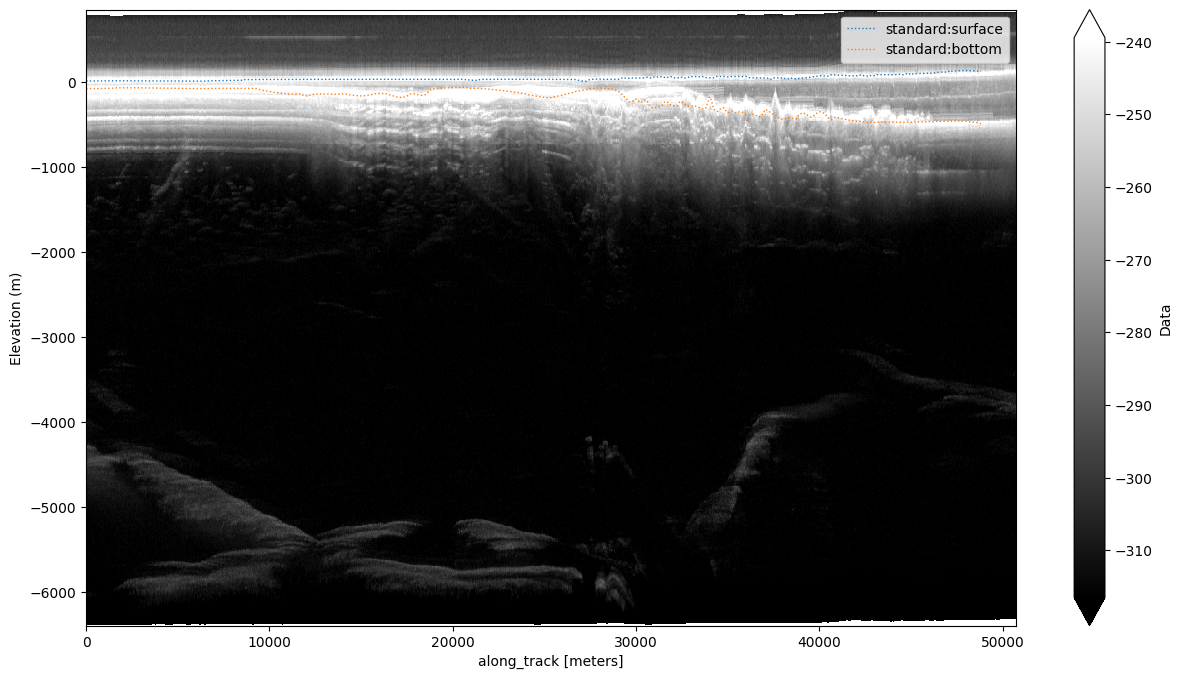

In [24]:
# visualize radargram

clb_min_pct, clb_max_pct = 30, 97

# Plot radargrams in elevation coordinates with layers
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 8))

# Frame 1 radargram in elevation
pwr_1_elev = 10*np.log10(np.abs(frame_1.Data))
vmax_1 = np.percentile(pwr_1_elev, clb_max_pct)
vmin_1 = np.percentile(pwr_1_elev, clb_min_pct)
pwr_1_elev.plot.imshow(x='along_track', y='wgs84', cmap='gray', ax=ax1, vmin=vmin_1, vmax=vmax_1)

# Plot layers using elevation data
for layer_name in layers:
    layers[layer_name]['wgs84'].plot(ax=ax1, x='along_track', linewidth=1, linestyle=':', label=layer_name)

# ax1.set_title(f"{intersect['collection_1']} - {intersect['id_1']} (Elevation view)")
ax1.set_ylabel('Elevation (m)')
ax1.legend()

In [25]:
# Get power (dB) of surface and bed
reflectivity = surface_bed_reflection_power(petermann_line_stac, opr=opr)
reflectivity = xopr.radar_util.add_along_track(reflectivity)


/home/m484s199/xopr-gline/src/xopr_gline/xopr_utils.py:82: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'slow_time' ('slow_time',) The recommendation is to set join explicitly for this case.
  reflectivity_dataset = xr.merge([reflectivity_dataset, flight_line_metadata])


In [26]:
# # Now lets define the "S shaped function" from Xia et al
# # which I belive is the error function erf in scipy.special
# # also need to calculate the third derivative to find the break in the ice bottom interfcae

# def erf_topography_model(x, a, b, x0, c):
#     """
#     S-shaped model for topographic transitions.
#     a: half-height of the step
#     b: transition steepness (1/width)
#     x0: center of the transition
#     c: vertical offset
#     """
#     return a * erf(b * (x - x0)) + c

# def get_derivatives(x, a, b, x0):
#     """
#     Calculates the 1st, 2nd, and 3rd analytical derivatives of the fit.
#     """
#     u = b * (x - x0)
#     # 1st derivative: Gaussian
#     z_prime = (2 * a * b / np.sqrt(np.pi)) * np.exp(-u**2)
#     # 2nd derivative
#     z_double_prime = -(4 * a * b**2 / np.sqrt(np.pi)) * u * np.exp(-u**2)
#     # 3rd derivative
#     z_triple_prime = (4 * a * b**3 / np.sqrt(np.pi)) * (2 * u**2 - 1) * np.exp(-u**2)
    
#     return z_prime, z_double_prime, z_triple_prime

Let's try a very simple approach first and just find the peak change in the bed power for a transition between grounded to floating

In [27]:
bed_power_grad = np.gradient(reflectivity['bed_power_dB']) # the Xia paper takes the second derivative but that looks worse
reflectivity['bed_power_grad'] = (('slow_time'), bed_power_grad)

# get the index of the peak bed power and grab the bed elevation index too
grad_max_idx = reflectivity['bed_power_grad'].argmax(dim="slow_time").data
grad_max = reflectivity['bed_power_grad'].max()

grad_slowtime = reflectivity['bed_power_grad']['slow_time'][grad_max_idx]
bed_point = layers['standard:bottom']['wgs84'].sel(slow_time=grad_slowtime.data, method='nearest')

In [28]:
reflectivity

<xarray.Dataset> Size: 6kB
Dimensions:           (slow_time: 71)
Coordinates:
  * slow_time         (slow_time) datetime64[ns] 568B 2010-04-20T18:14:05 ......
    along_track       (slow_time) float64 568B 0.0 467.7 ... 5.005e+04 5.052e+04
Data variables:
    surface_twtt      (slow_time) float64 568B nan nan nan ... 2.74e-06 2.74e-06
    bed_twtt          (slow_time) float64 568B nan nan ... 9.586e-06 9.586e-06
    surface_power_dB  (slow_time) float64 568B nan nan nan ... -234.7 -234.8
    bed_power_dB      (slow_time) float64 568B nan nan nan ... -239.5 -243.5
    GPS_time          (slow_time) float64 568B 1.272e+09 1.272e+09 ... 1.272e+09
    Latitude          (slow_time) float64 568B 80.92 80.92 80.91 ... 80.55 80.54
    Longitude         (slow_time) float64 568B -61.27 -61.26 ... -59.72 -59.71
    Elevation         (slow_time) float64 568B 484.3 484.0 483.1 ... 527.0 527.5
    bed_power_grad    (slow_time) float64 568B nan nan nan ... -2.931 -4.03
Attributes:
    segment:  3

Text(0.5, 1.0, 'Bed power gradient')

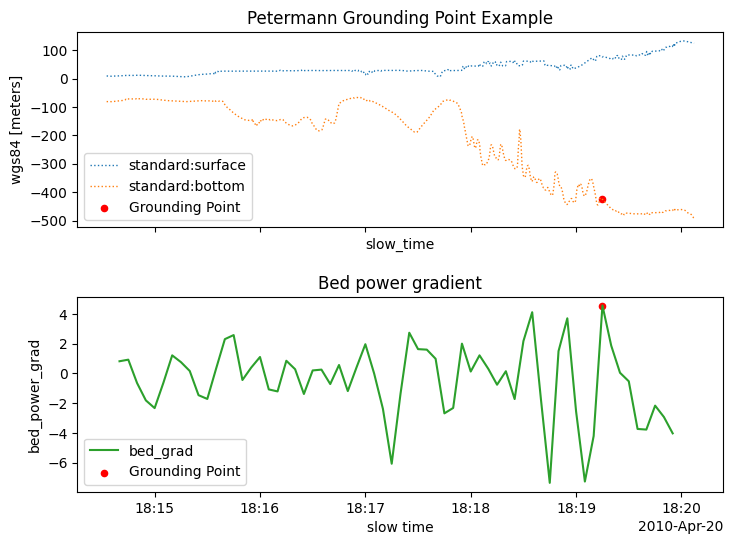

In [29]:
# Plot layers using elevation data and slow_time
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
fig.tight_layout(pad=4.0)

for layer_name in layers:
    layers[layer_name]['wgs84'].plot(ax=ax1, x='slow_time', linewidth=1, linestyle=':', label=layer_name)

ax1.scatter(bed_point['slow_time'], bed_point.data, color='r', s=20, label="Grounding Point")
ax1.set_title('Petermann Grounding Point Example')

# Plot layers using elevation data
#ax2 plot
reflectivity['bed_power_grad'].plot(ax=ax2, x='slow_time', label='bed_grad', color='tab:green')
ax2.scatter(grad_slowtime, grad_max, color='r', s=20, label="Grounding Point")

ax1.legend()
ax2.legend()
ax2.set_title('Bed power gradient')

**Issue**: Need to figure out how to make these both along track for the X

Attempt the S shaped error function 

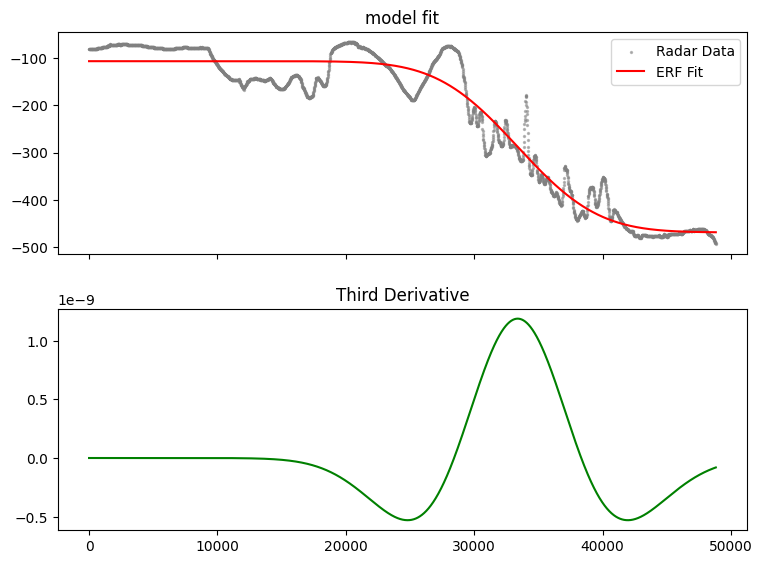

In [30]:
bed_elevation = layers['standard:bottom']['wgs84']
bottom_elevation_slow_time = bed_elevation['slow_time']

# Need to have some guesses for the p0 in curve_fit 
# Which is a non-linear curve fitting function
# a is amplitude
# b is slope
# x0 is the center point 
# c is the vertical offset

a_guess = (np.max(bed_elevation) - np.min(bed_elevation)) / 2
c_guess = np.mean(bed_elevation)
x0_guess = np.median(bed_elevation['along_track'])
b_guess = 0.1 # Gentle slope start
p0 = [a_guess, b_guess, x0_guess, c_guess]
lower_bounds = [-np.inf, 0, np.min(bed_elevation['along_track']), np.min(bed_elevation)]
upper_bounds = [np.inf, 5, np.max(bed_elevation['along_track']), np.max(bed_elevation)]


popt, _ = curve_fit(erf_topography_model, bed_elevation['along_track'], 
                    bed_elevation.data, p0=p0, bounds=(lower_bounds, upper_bounds))

a_fit, b_fit, x0_fit, c_fit = popt

_, _, z3 = get_derivatives(bed_elevation['along_track'], a_fit, b_fit, x0_fit)

y_fit = erf_topography_model(bed_elevation['along_track'], *popt)


fig2, (ax3,ax4) = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)

ax3.scatter(bed_elevation['along_track'], bed_elevation, s=2, color='gray', alpha=0.5, label='Radar Data')
ax3.plot(bed_elevation['along_track'], y_fit, 'r', label='ERF Fit')
ax3.set_title('model fit')
ax3.legend()

ax4.plot(bed_elevation['along_track'], z3, 'g', label='3rd Derivative')
ax4.set_title('Third Derivative')

fig2.tight_layout(pad=2.0)


So this is similiar to figure 7 in Xia et al., 2025. However the placement of the bottom plot's peak and the presumable seaward?? peak in power of that is definelty not the grounding line. The right most inflection point seems more plausible and a peak power upflow from that? 

In [31]:
# They do mention to smooth the data. I don't think it helps that much?
# Something like below is how to smooth with a butter filter

# sos_elevation = signal.butter(5, 0.09, btype='low', analog=False, output='sos')
# sos_reflection = signal.butter(5, 0.6, btype='low', analog=False, output='sos')

# filtered_elevation = signal.sosfiltfilt(sos_elevation, bed_elevation)
# filtered_reflection = signal.sosfiltfilt(sos_reflection, bed_power)


## Thoughts
- Need to get along track to work on power
- If lots of basal crevasses exist like this profile, grounding line must be upflow of that
- using some surface roughness and change in that would be a good parameter 